In [25]:
asd = "/workspace/data/segmentation_dataset_512/json_mix_with_score/mix/ASD/20160120_ASD_lat__V1-0001.json"
dhs = "/workspace/data/segmentation_dataset_512/json_mix_with_score/mix/DHS/20160927_DHS_lat_V1-0001.json"
lcs_hipoa = "/workspace/data/segmentation_dataset_512/json_mix_with_score/mix/LCS_HipOA/20170919_HipOA_lat_V1-0001.json"

In [26]:
one_file = lcs_hipoa

In [27]:
import json

with open(one_file, 'r') as file:
    one_data = json.load(file)

In [28]:
one_data.keys()

dict_keys(['bbox', 'disease', 'filter_info', 'frame_count', 'gait_cycle_index', 'label', 'none_index', 'video_name', 'video_path'])

In [29]:
from torchvision.io import read_video

vframes, *_ = read_video(one_data["video_path"], pts_unit='sec', output_format='TCHW')
vframes.shape

torch.Size([294, 3, 512, 512])

In [30]:
one_data_filter_info = one_data["filter_info"]
one_data_filter_info.keys()

dict_keys(['first_phase', 'second_phase'])

In [31]:
one_data["video_path"]

'/workspace/data/segmentation_dataset_512/fold0/val/ASD_not/20170919_HipOA_lat_V1-0001.mp4'

In [32]:
first_phase = one_data_filter_info['first_phase']
second_phase = one_data_filter_info['second_phase']

In [33]:
first_phase.keys()
first_phase['fold0'].keys()

dict_keys(['filtered_scores', 'sorted_idx'])

In [34]:
first_filtered_scores = first_phase['fold0']['filtered_scores']
first_sorted_idx = first_phase['fold0']['sorted_idx']

second_filtered_scores = second_phase['fold0']['filtered_scores']
second_sorted_idx = second_phase['fold0']['sorted_idx']



In [35]:
import torch

def normalize_scores(scores):
	scores_tensor = torch.tensor(scores)
	res = (scores_tensor - scores_tensor.min()) / (scores_tensor.max() - scores_tensor.min())
	return res.tolist()


In [36]:
max_idx = max(len(first_filtered_scores), len(second_filtered_scores))

combined_scores = []
for l, r in zip(first_filtered_scores, second_filtered_scores):
	print(len(l), len(r))
	combined_scores += normalize_scores(l) + normalize_scores(r)

if len(first_filtered_scores) != len(second_filtered_scores):
	combined_scores += normalize_scores(first_filtered_scores[max_idx-1])

assert len(combined_scores) == vframes.shape[0]

combined_scores_idx = []
for l, r in zip(first_sorted_idx, second_sorted_idx):
	print(len(l), len(r))
	combined_scores_idx += l + r

if len(first_sorted_idx) != len(second_sorted_idx):
	combined_scores_idx += first_sorted_idx[max_idx-1]

assert len(combined_scores_idx) == vframes.shape[0]




19 11
20 11
23 26
11 22
29 11
17 11
18 11
18 11
19 11
20 11
23 26
11 22
29 11
17 11
18 11
18 11


In [37]:
vframes.shape

torch.Size([294, 3, 512, 512])

In [38]:
len(first_filtered_scores), len(second_filtered_scores)

(9, 8)

In [39]:
combined_scores, combined_scores_idx

([0.9892274737358093,
  1.0,
  0.6538040041923523,
  0.7282787561416626,
  0.980721116065979,
  0.6501070261001587,
  0.6627160310745239,
  0.49007341265678406,
  0.3277895450592041,
  0.20411573350429535,
  0.0,
  0.38453948497772217,
  0.8233497738838196,
  0.48423805832862854,
  0.1385156363248825,
  0.2213941216468811,
  0.42393758893013,
  0.11490056663751602,
  0.2318318486213684,
  0.69571453332901,
  0.6053373217582703,
  0.40228700637817383,
  0.27567580342292786,
  1.0,
  0.2639318108558655,
  0.3082924783229828,
  0.8258531093597412,
  0.5512374639511108,
  0.0,
  0.39797067642211914,
  0.27282583713531494,
  0.47107774019241333,
  0.45743048191070557,
  0.5508997440338135,
  0.7031728625297546,
  0.712817907333374,
  0.5000978708267212,
  0.7628410458564758,
  0.7423378825187683,
  0.8046092987060547,
  1.0,
  0.7253518104553223,
  0.5968073010444641,
  0.8732864856719971,
  0.44888395071029663,
  0.4450805187225342,
  0.4683792293071747,
  0.3692016303539276,
  0.0,
  0.27

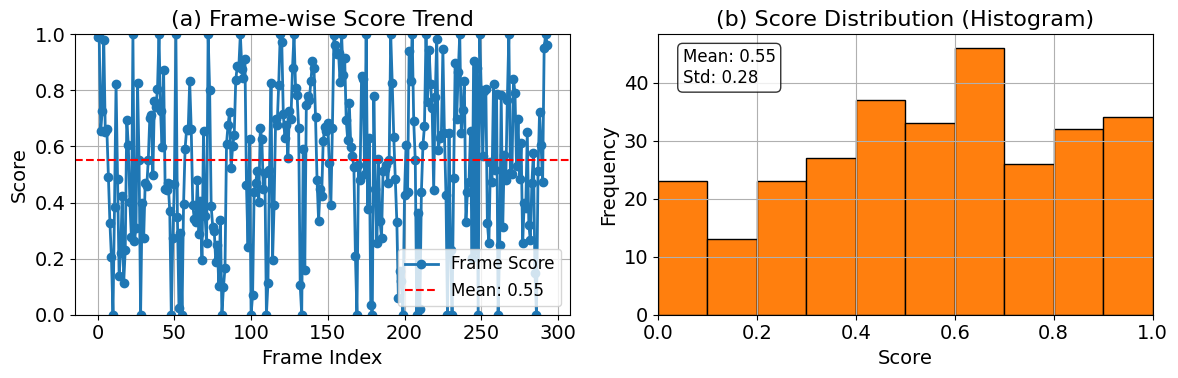

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# 示例分数数据
scores = combined_scores
frame_indices = list(range(len(scores)))
mean_score = np.mean(scores)
std_score = np.std(scores)

# 创建图像和子图
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# 设置全局字体大小
plt.rcParams.update({'font.size': 14})

# --- (a) 分数 vs 帧索引 ---
axs[0].plot(frame_indices, scores, marker='o', color='tab:blue', linewidth=2, label='Frame Score')
axs[0].axhline(mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.2f}')
axs[0].set_title("(a) Frame-wise Score Trend", fontsize=16)
axs[0].set_xlabel("Frame Index", fontsize=14)
axs[0].set_ylabel("Score", fontsize=14)
axs[0].set_ylim(0, 1)
axs[0].grid(True)
axs[0].legend(fontsize=12)

# --- (b) 得分直方图 ---
axs[1].hist(scores, bins=10, edgecolor='black', color='tab:orange')
axs[1].set_title("(b) Score Distribution (Histogram)", fontsize=16)
axs[1].set_xlabel("Score", fontsize=14)
axs[1].set_ylabel("Frequency", fontsize=14)
axs[1].set_xlim(0, 1)
axs[1].grid(True)

# 添加文本统计框
textstr = f'Mean: {mean_score:.2f}\nStd: {std_score:.2f}'
axs[1].text(0.05, 0.95, textstr, transform=axs[1].transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [41]:
import matplotlib.pyplot as plt

def plot_sample_visualization(original_frames, scores, selected_indices, removed_indices, entropy_list, flow_magnitude_list):
    fig, axs = plt.subplots(5, 1, figsize=(14, 10))

    # 1. 原始帧序列
    for i, frame in enumerate(original_frames):
        axs[0].imshow(frame)
        axs[0].set_title("Original Frame #" + str(i))
    
    # 2. 保留帧
    for i in selected_indices:
        axs[1].imshow(original_frames[i])
        axs[1].set_title(f"Selected Frame #{i}, Score: {scores[i]:.2f}")

    # 3. 去除帧（可选）
    for i in removed_indices:
        axs[2].imshow(original_frames[i])
        axs[2].set_title(f"Removed Frame #{i}, Score: {scores[i]:.2f}")

    # 4. 分数折线图
    axs[3].plot(scores, marker='o', label='Score')
    axs[3].scatter(selected_indices, [scores[i] for i in selected_indices], color='red', label='Selected')
    axs[3].set_title("FilterNet Scores")
    axs[3].legend()

    # 5. 帧信息统计图
    axs[4].plot(entropy_list, label='Entropy')
    axs[4].plot(flow_magnitude_list, label='Optical Flow Magnitude')
    axs[4].set_title("Frame Statistics")
    axs[4].legend()

    plt.tight_layout()
    plt.show()


# compare the difference between frames in the gait cycle

In [42]:
gait_cycle_index = one_data["gait_cycle_index"]

In [43]:
def split_gait_cycle(
    video_tensor: torch.Tensor, gait_cycle_index: list, gait_cycle: int
):

    use_idx = []
    ans_list = []

    if gait_cycle == 0 or len(gait_cycle_index) == 2:
        for i in range(0, len(gait_cycle_index) - 1, 2):
            ans_list.append(
                video_tensor[gait_cycle_index[i] : gait_cycle_index[i + 1], ...]
            )
            use_idx.append(gait_cycle_index[i])

    elif gait_cycle == 1:

        # FIXME: maybe here do not -1 for upper limit.
        for i in range(1, len(gait_cycle_index) - 1, 2):
            ans_list.append(
                video_tensor[gait_cycle_index[i] : gait_cycle_index[i + 1], ...]
            )
            use_idx.append(gait_cycle_index[i])

    # print(f"used split gait cycle index: {use_idx}")

    return ans_list, use_idx  # needed gait cycle video tensor


In [44]:
#  * step1: first find the phase frames (pack) and phase index.
first_phase, first_phase_idx = split_gait_cycle(
            vframes, gait_cycle_index, 0
        )
second_phase, second_phase_idx = split_gait_cycle(
            vframes, gait_cycle_index, 1
        )

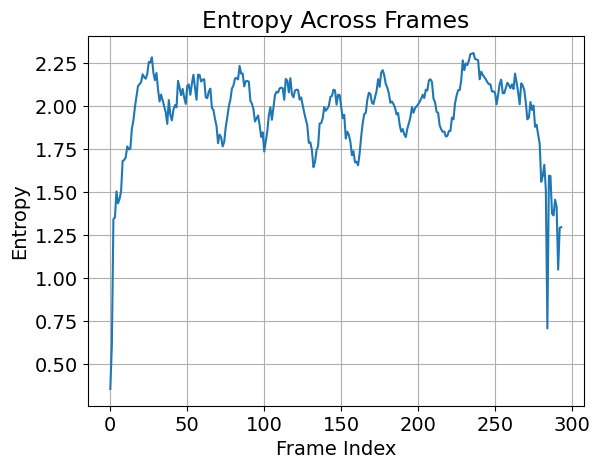

In [45]:
import cv2
import numpy as np

def calculate_entropy(image: np.ndarray) -> float:
    """
    计算单张图像的熵（支持 RGB 或灰度图像）

    Args:
        image (np.ndarray): 输入图像，形状为 (H, W, 3) 或 (H, W)

    Returns:
        float: 图像熵值
    """
    # 转灰度图
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # 计算灰度直方图（0-255，共 256 个 bin）
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()

    # 去掉为 0 的概率值，避免 log(0)
    hist_nonzero = hist[hist > 0]

    # 熵计算公式：-∑p*log2(p)
    entropy = -np.sum(hist_nonzero * np.log2(hist_nonzero))

    return entropy

entropy_list = []

for frame in vframes:  # original_frames 是帧的 np.array 列表
    frame = frame.permute(1, 2, 0).numpy()  # 转换为 HWC 格式
    entropy_val = calculate_entropy(frame)
    entropy_list.append(entropy_val)

import matplotlib.pyplot as plt

plt.plot(entropy_list)
plt.title("Entropy Across Frames")
plt.xlabel("Frame Index")
plt.ylabel("Entropy")
plt.grid(True)
plt.show()


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def ssim(img1, img2, C1=6.5025, C2=58.5225):
    """
    计算两张灰度图像之间的结构相似度 SSIM。
    参数：
        img1, img2: 输入图像（numpy 数组，灰度图，值范围 0-255）
    返回：
        SSIM 值（单个标量）
    """
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    # 计算均值（高斯滤波代替滑窗）
    mu1 = gaussian_filter(img1, sigma=1.5)
    mu2 = gaussian_filter(img2, sigma=1.5)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    # 计算方差和协方差
    sigma1_sq = gaussian_filter(img1 ** 2, sigma=1.5) - mu1_sq
    sigma2_sq = gaussian_filter(img2 ** 2, sigma=1.5) - mu2_sq
    sigma12 = gaussian_filter(img1 * img2, sigma=1.5) - mu1_mu2

    # SSIM 公式
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean()

def rgb_to_gray(img):
    """Convert RGB image to grayscale using luminosity method."""
    if img.ndim == 3 and img.shape[2] == 3:
        return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    return img

def compute_frame_difference(img1, img2, method='l1'):
    """Compute difference between two frames using L1, MSE, or SSIM."""
    # img1 = rgb_to_gray(img1)
    # img2 = rgb_to_gray(img2)

    if method == 'l1':
        diff = np.abs(img1.astype(np.float32) - img2.astype(np.float32))
        return np.mean(diff)
    elif method == 'mse':
        diff = (img1.astype(np.float32) - img2.astype(np.float32)) ** 2
        return np.mean(diff)
    elif method == 'ssim':
        score = ssim(img1, img2)
        return score  # 差异值：越大表示变化越大
    else:
        raise ValueError("Unsupported method: choose 'l1', 'mse', or 'ssim'")


def compute_avg_variation(indices, all_frames, method='l1'):
    diffs = []
    for i in range(len(indices) - 1):
        f1 = all_frames[indices[i]].numpy()  # CTHW -> HWC
        f2 = all_frames[indices[i + 1]].numpy()
        f1 = np.transpose(f1, (1, 2, 0))  # C,H,W → H,W,C
        f2 = np.transpose(f2, (1, 2, 0))
        diff = compute_frame_difference(f1, f2, method=method)
        diffs.append(diff)
    return np.mean(diffs), diffs


# ----------------------
# 比较均匀采样 vs. FilterNet选择
# ----------------------
def calc_uniform_vs_filternet(frames, phase_idx, uniform_num:int=8, method='ssim'):
	uniform_indices = np.linspace(0, len(frames) - 1, num=uniform_num, dtype=int)  # 从0到len(frames)-1之间均匀选出8个索引
	filternet_indices = sorted(phase_idx[:uniform_num])  # 取前8个索引作为FilterNet选择的示例

	avg_u, diffs_u = compute_avg_variation(uniform_indices, frames, method=method)
	avg_f, diffs_f = compute_avg_variation(filternet_indices, frames, method=method)
	avg_all, diffs_all = compute_avg_variation(list(range(len(frames))), frames, method=method)

	# 打印分析报告
	# print("="*50)
	# print("🧪 Frame Difference Evaluation")
	# print(f"• Uniform Sampling Indices     : {uniform_indices}")
	# print(f"• FilterNet Top-score Indices  : {filternet_indices}")
	# print(f"• All Frames Indices           : {list(range(len(frames)))}")
	# print("-" * 50)
	# print(f"Uniform Sampling   → Avg Δ: {avg_u:.2f} | Std: {np.std(diffs_u):.2f}")
	# print(f"FilterNet Selection → Avg Δ: {avg_f:.2f} | Std: {np.std(diffs_f):.2f}")
	# print("="*50)

	return avg_u, avg_f, diffs_u, diffs_f, avg_all, diffs_all

uniform_ssim = []
filternet_ssim = []
all_ssim = []

for f, idx in zip(first_phase, first_sorted_idx):
	avg_u, avg_f, diffs_u, diffs_f, avg_all, diffs_all = calc_uniform_vs_filternet(f, idx, method='l1')
	uniform_ssim.append(avg_u)
	filternet_ssim.append(avg_f)
	all_ssim.append(avg_all)

for f, idx in zip(second_phase, second_sorted_idx):
	avg_u, avg_f, diffs_u, diffs_f, avg_all, diffs_all = calc_uniform_vs_filternet(f, idx, method='l1')
	uniform_ssim.append(avg_u)
	filternet_ssim.append(avg_f)
	all_ssim.append(avg_all)
     
# 打印最终结果
print("="*50)
print("📊 Overall l1 Analysis")
print(f"Uniform Sampling Avg SSIM: {np.mean(uniform_ssim):.2f} | Std: {np.std(uniform_ssim):.2f}")
print(f"FilterNet Selection Avg SSIM: {np.mean(filternet_ssim):.2f} | Std: {np.std(filternet_ssim):.2f}")
print(f"All Frames Avg SSIM: {np.mean(all_ssim):.2f} | Std: {np.std(all_ssim):.2f}")	
print("="*50)


# mse 
uniform_ssim = []
filternet_ssim = []
all_ssim = []

for f, idx in zip(first_phase, first_sorted_idx):
	avg_u, avg_f, diffs_u, diffs_f, avg_all, diffs_all = calc_uniform_vs_filternet(f, idx, method='mse')
	uniform_ssim.append(avg_u)
	filternet_ssim.append(avg_f)
	all_ssim.append(avg_all)

for f, idx in zip(second_phase, second_sorted_idx):
	avg_u, avg_f, diffs_u, diffs_f, avg_all, diffs_all = calc_uniform_vs_filternet(f, idx, method='mse')
	uniform_ssim.append(avg_u)
	filternet_ssim.append(avg_f)
	all_ssim.append(avg_all)
     
# 打印最终结果
print("="*50)
print("📊 Overall mse Analysis")
print(f"Uniform Sampling Avg SSIM: {np.mean(uniform_ssim):.2f} | Std: {np.std(uniform_ssim):.2f}")
print(f"FilterNet Selection Avg SSIM: {np.mean(filternet_ssim):.2f} | Std: {np.std(filternet_ssim):.2f}")
print(f"All Frames Avg SSIM: {np.mean(all_ssim):.2f} | Std: {np.std(all_ssim):.2f}")
print("="*50)

# ssim
uniform_ssim = []
filternet_ssim = []
all_ssim = []

for f, idx in zip(first_phase, first_sorted_idx):
	avg_u, avg_f, diffs_u, diffs_f, avg_all, diffs_all = calc_uniform_vs_filternet(f, idx, method='ssim')
	uniform_ssim.append(avg_u)
	filternet_ssim.append(avg_f)
	all_ssim.append(avg_all)

for f, idx in zip(second_phase, second_sorted_idx):
	avg_u, avg_f, diffs_u, diffs_f, avg_all, diffs_all = calc_uniform_vs_filternet(f, idx, method='ssim')
	uniform_ssim.append(avg_u)
	filternet_ssim.append(avg_f)
	all_ssim.append(avg_all)
     
# 打印最终结果
print("="*50)
print("📊 Overall SSIM Analysis")
print(f"Uniform Sampling Avg SSIM: {np.mean(uniform_ssim):.2f} | Std: {np.std(uniform_ssim):.2f}")
print(f"FilterNet Selection Avg SSIM: {np.mean(filternet_ssim):.2f} | Std: {np.std(filternet_ssim):.2f}")
print(f"All Frames Avg SSIM: {np.mean(all_ssim):.2f} | Std: {np.std(all_ssim):.2f}")
print("="*50)

📊 Overall l1 Analysis
Uniform Sampling Avg SSIM: 4.89 | Std: 0.90
FilterNet Selection Avg SSIM: 3.92 | Std: 0.53
All Frames Avg SSIM: 3.41 | Std: 0.33
📊 Overall mse Analysis
Uniform Sampling Avg SSIM: 294.71 | Std: 71.81
FilterNet Selection Avg SSIM: 221.54 | Std: 44.41
All Frames Avg SSIM: 178.86 | Std: 23.92
📊 Overall SSIM Analysis
Uniform Sampling Avg SSIM: 0.89 | Std: 0.01
FilterNet Selection Avg SSIM: 0.91 | Std: 0.01
All Frames Avg SSIM: 0.91 | Std: 0.01
